# Assignment 1

<b>Group [fill in group number]</b>
* <b> Student 1 </b> : FILL IN STUDENT NAME + STUDENT NUMBER
* <b> Student 2 </b> : FILL IN STUDENT NAME + STUDENT NUMBER

**Reading material**
* [1] Mikolov, Tomas, et al. "[Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781)" Advances in neural information processing systems. 2013. 

<b><font color='red'>NOTE</font></b> When submitting your notebook, please make sure that the training history of your model is visible in the output. This means that you should **NOT** clean your output cells of the notebook. Make sure that your notebook runs without errors in linear order.



# Question 1 - Keras implementation (10 pt)

### Word embeddings
Build word embeddings with a Keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training. Use a window size of 2 to train the embeddings (`window_size` in the jupyter notebook). 

1. Build word embeddings of length 50, 150 and 300 using the Skipgram model
2. Build word embeddings of length 50, 150 and 300 using CBOW model
3. Analyze the different word embeddings:
    - Implement your own function to perform the analogy task (see [1] for concrete examples). Use the same distance metric as in the paper. Do not use existing libraries for this task such as Gensim. 
Your function should be able to answer whether an analogy like: "a king is to a queen as a man is to a woman" ($e_{king} - e_{queen} + e_{woman} \approx e_{man}$) is true. $e_{x}$ denotes the embedding of word $x$. We want to find the word $p$ in the vocabulary, where the embedding of $p$ ($e_p$) is the closest to the predicted embedding (i.e. result of the formula). Then, we can check if $p$ is the same word as the true word $t$.
    - Give at least 5 different  examples of analogies.
    - Compare the performance on the analogy tasks between the word embeddings and briefly discuss your results.

4. Discuss:
  - Given the same number of sentences as input, CBOW and Skipgram arrange the data into different number of training samples. Which one has more and why?


<b>HINT</b> See practical 3.1 for some helpful code to start this assignment.


### Import libraries

In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import keras.backend as K
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence

# other helpful libraries
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
import pandas as pd

Using TensorFlow backend.


In [0]:
print(tf.__version__) #  check what version of TF is imported

2.2.0-rc4


### Import file

If you use Google Colab, you need to mount your Google Drive to the notebook when you want to use files that are located in your Google Drive. Paste the authorization code, from the new tab page that opens automatically when running the cell, in the cell below.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Navigate to the folder in which `alice.txt` is located. Make sure to start path with '/content/drive/My Drive/' if you want to load the file from your Google Drive.

In [0]:
cd '/content/drive/My Drive/Università/Deep Learning/Assignment 1'

/content/drive/My Drive/Università/Deep Learning/Assignment 1


In [0]:
file_name = 'alice.txt'
corpus = open(file_name).readlines()

### Data preprocessing

See Practical 3.1 for an explanation of the preprocessing steps done below.

In [0]:
# Removes sentences with fewer than 3 words
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

# remove punctuation in text and fit tokenizer on entire corpus
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)

# convert text to sequence of integer values
corpus = tokenizer.texts_to_sequences(corpus)
n_samples = sum(len(s) for s in corpus) # total number of words in the corpus
V = len(tokenizer.word_index) + 1 # total number of unique words in the corpus

In [0]:
n_samples, V

(27165, 2557)

In [0]:
# example of how word to integer mapping looks like in the tokenizer
print(list((tokenizer.word_index.items()))[:5])

[('the', 1), ('and', 2), ('to', 3), ('a', 4), ('it', 5)]


In [0]:
# parameters
window_size = 2
window_size_corpus = 4

## Task 1.1 - Skipgram
Build word embeddings of length 50, 150 and 300 using the Skipgram model.

In [0]:
#prepare data for skipgram
def generate_data_skipgram(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
                    
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    all_in.append(word)
                    # Add one-hot of the context words
                    all_out.append(to_categorical(words[i], V))
                                      
    return (np.array(all_in),np.array(all_out))

In [0]:
# create training data
x, y = generate_data_skipgram(corpus,window_size,V)

In [0]:
x.shape, y.shape

((94556,), (94556, 2557))

In [0]:
dim = 150 # dimension of word embedding

# model
skipgram = Sequential(name='Skipgram')
skipgram.add(Embedding(V, dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram.add(Reshape((dim,)))
skipgram.add(Dense(V, activation='softmax',kernel_initializer='glorot_uniform'))
skipgram.compile(loss='categorical_crossentropy',
                 optimizer='adadelta')

In [0]:
skipgram.summary()
plot_model(skipgram, show_shapes = True, show_layer_names=False)

<b>HINT</b>: To increase training speed of your model, you can use the free available GPU power in Google Colab. Go to `Edit` --> `Notebook Settings` --> select `GPU` under `hardware accelerator`.

In [0]:
# train skipgram model
skipgram.fit(x, y, batch_size=64, epochs=10)

In [0]:
# save embeddings for vectors of length 50, 150 and 300 using skipgram model
weights = skipgram.get_weights()
print("Weights for the embedding layer: ",  weights[0].shape)
print("Weights for the dense layer: ",  weights[1].shape)
print("Biases for the dense layer: ",  weights[2].shape)

# Get the embedding matrix
embedding = weights[0]

# get word embeddings for each word in the vocabulary, write to file
f = open('embeddings/skipgram_150.txt' ,'w')
f.write(" ".join([str(V-1),str(dim)]))
f.write("\n")

for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(embedding[i,:]))))
    f.write("\n")
f.close()

Weights for the embedding layer:  (2557, 150)
Weights for the dense layer:  (150, 2557)
Biases for the dense layer:  (2557,)


## Task 1.2 - CBOW

Build word embeddings of length 50, 150 and 300 using CBOW model.

In [0]:
# create training data
def generate_data_cbow(corpus, window_size, V):
  all_in = []
  all_out = []

  for line in corpus:
    for i_word, word in enumerate(line):
      before = i_word - window_size
      after = i_word + window_size + 1 #+1 to use it in range
      all_out.append(to_categorical(word, V))
      
      temp_in = []
      for i_input in range(before, after):
        if i_input != i_word and 0 <= i_input < len(line):
          temp_in.append(line[i_input])
        elif i_input != i_word:
          temp_in.append(0)
      all_in.append(temp_in)
  
  return np.array(all_in), np.array(all_out)

x, y = generate_data_cbow(corpus, window_size, V)
x.shape, y.shape

((27165, 4), (27165, 2557))

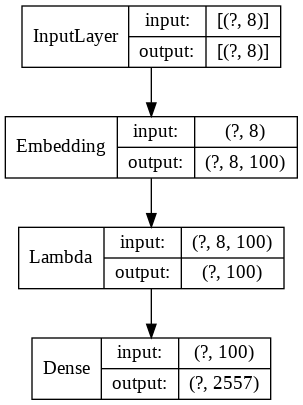

In [0]:
# create CBOW architecture
dim_emb = 100

# model
cbow = Sequential()
cbow.add(Embedding(V, dim_emb, embeddings_initializer='glorot_uniform', mask_zero=True, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1)))
cbow.add(Dense(V, activation='softmax', kernel_initializer='glorot_uniform'))
cbow.compile(loss='categorical_crossentropy', optimizer='adadelta')

# plot model
plot_model(cbow, show_shapes = True, show_layer_names=False)

In [0]:
# train CBOW model
cbow.fit(x, y, batch_size=64, epochs=10)

Epoch 1/10
425/425 [==============================] - 2s 5ms/step - loss: 7.8468
Epoch 2/10
425/425 [==============================] - 2s 5ms/step - loss: 7.8466
Epoch 3/10
425/425 [==============================] - 2s 5ms/step - loss: 7.8463
Epoch 4/10
425/425 [==============================] - 2s 5ms/step - loss: 7.8461
Epoch 5/10
425/425 [==============================] - 2s 5ms/step - loss: 7.8458
Epoch 6/10
425/425 [==============================] - 2s 5ms/step - loss: 7.8456
Epoch 7/10
425/425 [==============================] - 2s 5ms/step - loss: 7.8453
Epoch 8/10
425/425 [==============================] - 2s 5ms/step - loss: 7.8451
Epoch 9/10
425/425 [==============================] - 2s 5ms/step - loss: 7.8448
Epoch 10/10
425/425 [==============================] - 2s 5ms/step - loss: 7.8446


In [0]:
# save embeddings for vectors of length 50, 150 and 300 using CBOW model
weights = cbow.get_weights()
print("Weights for the embedding layer: ",  weights[0].shape)

# get embedding matrix
embedding = weights[0]

# get word embedding for each word in the vocabolary, write to file
f = open('embeddings/cbow_150.txt' ,'w')
f.write(" ".join([str(V-1),str(dim_emb)])) # 
f.write("\n")

for word, i in tokenizer.word_index.items():
  f.write(word)
  f.write(" ")
  f.write(" ".join(map(str, list(embedding[i,:]))))
  f.write("\n")
f.close()

Weights for the embedding layer:  (2557, 150)


## Task 1.3 - Analogy function

Implement your own function to perform the analogy task (see [1] for concrete examples). Use the same distance metric as in [1]. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an analogy like: "a king is to a queen as a man is to a woman" ($e_{king} - e_{queen} + e_{woman} \approx e_{man}$) is true. 

In a perfect scenario, we would like that this analogy ( $e_{king} - e_{queen} + e_{woman}$) results in the embedding of the word "man". However, it does not always result in exactly the same word embedding. The result of the formula is called the expected or the predicted word embedding. In this context, "man" is called the true or the actual word $t$. We want to find the word $p$ in the vocabulary, where the embedding of $p$ ($e_p$) is the closest to the predicted embedding (i.e. result of the formula). Then, we can check if $p$ is the same word as the true word $t$.  

You have to answer an analogy function using each embedding for both CBOW and Skipgram model. This means that for each analogy we have 6 outputs. Show the true word (with distance similarity value between predicted embedding and true word embedding, i.e. `sim1`) , the predicted word (with distance similarity value between predicted embedding and the embedding of the word in the vocabulary that is closest to this predicted embedding, i.e. `sim2`) and a boolean answer whether the predicted word **exactly** equals the true word. 

<b>HINT</b>: to visualize the results of the analogy tasks , you can print them in a table. An example is given below.


| Analogy task | True word (sim1)  | Predicted word (sim2) | Embedding | Correct?|
|------|------|------|------|------|
|  queen is to king as woman is to ?	 | man (sim1) | predictd_word(sim2) | SG_50 | True / False|

* Give at least 5 different  examples of analogies.
* Compare the performance on the analogy s between the word embeddings and briefly discuss your results.

In [0]:
from os import listdir
from os.path import isfile, join
from scipy import spatial

def embeds(word, directory='./embeddings'):
  emb_files = [file for file in listdir(directory) if isfile(join(directory, file))]
  base_file = open(join(directory,emb_files[0]), 'r')
  base_lines = base_file.readlines()
  base_file.close()

  emb_final = []
  for i, line in enumerate(base_lines):
    if word in line:
      for file in emb_files:
        file = open(join(directory,file), 'r')
        lines = file.readlines()
        emb = [float(x) for x in lines[i].split()[1:]]
        emb_final.append(np.array(emb))
        file.close()
      break

  return zip(emb_final, emb_files)

def closest(emb, emb_file, directory='./embeddings'):
  file = open(join(directory, emb_file), 'r')
  lines = file.readlines()[1:]

  for l in lines:
    n_emb = [float(x) for x in l.split()[1:]]
    dist = 1 - spatial.distance.cosine(n_emb, emb)
  



['skipgram_100.txt', 'skipgram_50.txt', 'skipgram_150.txt', 'cbow_50.txt', 'cbow_100.txt', 'cbow_150.txt']


[((100,), 'skipgram_100.txt'),
 ((50,), 'skipgram_50.txt'),
 ((150,), 'skipgram_150.txt'),
 ((50,), 'cbow_50.txt'),
 ((100,), 'cbow_100.txt'),
 ((150,), 'cbow_150.txt')]

In [0]:
x = 'ciao 2.3 2.4 1.3 545 232.5'
x = [float(n) for n in x.split()[1:]]
x

[2.3, 2.4, 1.3, 545.0, 232.5]

## Task 1.4 - Discussion
Answer the following question:
* Given the same number of sentences as input, CBOW and Skipgram arrange the data into different number of training samples. Which one has more and why?


# Question 2 - Peer review (0 pt):
Finally, each group member must write a single paragraph outlining their opinion on the work distribution within the group. Did every group member
contribute equally? Did you split up tasks in a fair manner, or jointly worked through the exercises. Do you think that some members of your group deserve a different grade from others? You can use the table below to make an overview of how the tasks were divided:



| Student name | Task  |
|------|------|
|  student name 1  | task x |
| student name 2  | task x|
| everyone | task x|
